# Bluebook for Bulldozers

In [1]:
from fastai.tabular.all import *
from fastbook import *
from sklearn.ensemble import RandomForestRegressor

## Download the dataset

In [2]:
# TODO: Consider making a tiny fastkaggle package - or putting it in fastcore.
# that essentially does this, and allows you to copy pasta your username and api key.

Before we get started, ensure that your Kaggle API credentials file exists in the expected place:

In [3]:
assert Path('~/.kaggle/kaggle.json').expanduser().exists()

If the above cell fails, you'll need to create a credentials file manually at `~/.kaggle/kaggle.json` with contents:

```json
{"username":"user","key":"12345"}
```

replacing `user` with your Kaggle username and `12345` with an API key. An actual key will be much longer and contain both letters and numbers.

If you don't have a key, you can get one by creating an API token on the Kaggle website. Go to https://www.kaggle.com, click on your profile icon in the top-right, click _Account_, scroll down to the _API_ section, and click _Create New API token_. This will download a `kaggle.json` file which looks like the above. Finally, move the token file to `~/.kaggle/kaggle.json` and rerun the previous cell to ensure that it's in the right place.

Download the dataset using the Kaggle API client:

In [4]:
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)
path

Path('/Users/seem/.fastai/archive/bluebook-for-bulldozers')

Extract the contents of the downloaded archive:

In [5]:
#A little trick to display paths relative to the data directory, for convenience
Path.BASE_PATH = path

In [6]:
if not path.exists() or not path.ls(file_type='text'):
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))
path.ls(file_type='text')

(#7) [Path('random_forest_benchmark_test.csv'),Path('Valid.csv'),Path('median_benchmark.csv'),Path('Test.csv'),Path('ValidSolution.csv'),Path('Machine_Appendix.csv'),Path('TrainAndValid.csv')]

Read the dataset to a pandas dataframe:

## Features

TODO: Could `tabular_learner` also provide default `procs` that work 90% of the time?

In [186]:
def make_dates(df):
    for c in df:
        #Assume that numeric cols are not datetime, even though they could be in UNIX format
        if np.issubdtype(df[c].dtype,np.number) or np.issubdtype(df[c],bool): continue
        try: make_date(df, c)
        #except (TypeError, pd.errors.ParserError, ParserError, ValueError): pass
        except ValueError: pass

In [187]:
def cont_cat_date_split(df, max_card=20, dep_var=None):
    cont_names, cat_names, date_names = [], [], []
    for label in df:
        if label in L(dep_var): continue
        if ((pd.api.types.is_integer_dtype(df[label].dtype) and
            df[label].unique().shape[0] > max_card) or
            pd.api.types.is_float_dtype(df[label].dtype)):
            cont_names.append(label)
        elif np.issubdtype(df[label].dtype,np.datetime64): date_names.append(label)
        else: cat_names.append(label)
    return cont_names,cat_names,date_names

In [234]:
class AddDatepart(TabularProc):
    def __init__(self, prefix=None, drop=True, time=False):
        store_attr()
        self._add_datepart = partial(add_datepart, **locals())
    def encodes(self, to):
        for c in to.date_names:
            #TODO: add datepart cols to cat_names/cont_names...
            self._add_datepart(to.items, c)
    #def decodes(self, to):
    #    if not drop: return self.to.items
    #    for c in to.date_names: self._add_datepart(to.items, c)

In [207]:
class MyTabularPandas(TabularPandas):
    def __init__(self, *args, date_names=None, **kwargs):
        self.date_names = L(date_names)
        super().__init__(*args, **kwargs)

The evaluation metric is RMSLE, so take the log of the output to directly optimise for that instead of MSE. I believe GBMs and NNs can directly optimise for RMSLE instead of indirectly like this? (**TODO: Confirm**)

Trade-offs to `add_datepart` as a pre-processing function vs a `TabularProc`:

- I'm not sure how likely it is to correctly infer which columns are dates.
- Lose the flexibility of deciding how to treat outputs as cont/cat - particularly the dependence on `max_card`.
- It's only one additional line of code... Much of a muchness?
- Is there benefit to having the decoded datetime?

In [262]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var]) # Random forests can't train directly on rmsle so this gets closer, better acc
df = add_datepart(df, 'saledate')
cont,cat = cont_cat_split(df, dep_var=dep_var, max_card=1) #TODO: max_card needed?
procs = [Categorify, FillMissing, AddDatepart]
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = df.index[ cond]
valid_idx = df.index[~cond]
splits = (list(train_idx),list(valid_idx))
to = MyTabularPandas(df, procs, cat, cont, date_names=date, y_names=dep_var, splits=splits)

In [263]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [264]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [260]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
m = rf(xs, y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.1714, 0.233854)

**TODO:** Can't we use `tabular_learner` here with random forest? Or does it only support NNs?

In [266]:
r_mse(m.oob_prediction_, y)

0.217038

## Simplify the model

In [295]:
def rf_feat_importance(m, df):
    std = np.std([o.feature_importances_ for o in m.estimators_], axis=0)
    return pd.DataFrame({'col':df.columns,'imp':m.feature_importances_,'std':std}
                       ).sort_values('imp', ascending=False)

In [296]:
fi = rf_feat_importance(m, xs)
fi[:10]

,col,imp,std
57,YearMade,0.2015,0.0417
6,ProductSize,0.1586,0.0587
12,Enclosure,0.0781,0.0787
3,fiSecondaryDesc,0.0714,0.0266
65,saleElapsed,0.0612,0.0064
1,fiModelDesc,0.0475,0.0290
7,fiProductClassDesc,0.0469,0.0222
54,ModelID,0.0461,0.0202
2,fiBaseModel,0.0383,0.0352
52,SalesID,0.0305,0.0077


In [324]:
def plot_fi(fi):
    cols = len(fi)
    figsize = (12, cols/4.3)
    fi[:cols][::-1].plot.barh('col', 'imp', yerr='std', figsize=figsize, legend=False,
                              xlabel='Column', ylabel='Importance')

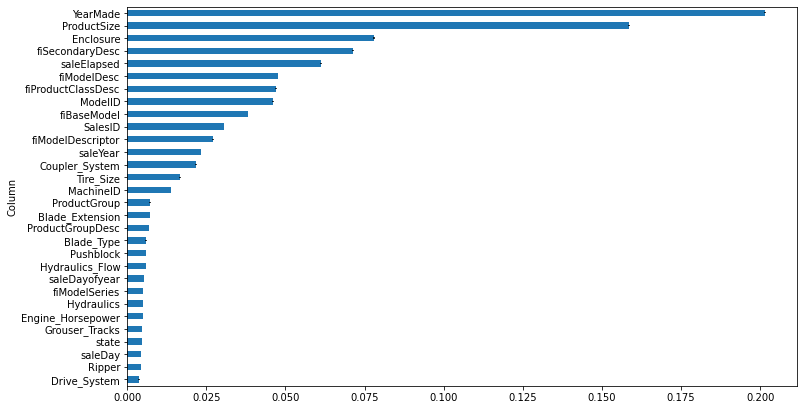

In [325]:
plot_fi(fi[:30])

In [327]:
to_keep = fi[fi.imp>0.005].col
len(to_keep)

23

In [328]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [329]:
m = rf(xs_imp, y)

In [330]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.185387, 0.236907)

In [331]:
len(xs.columns), len(xs_imp.columns)

(66, 23)

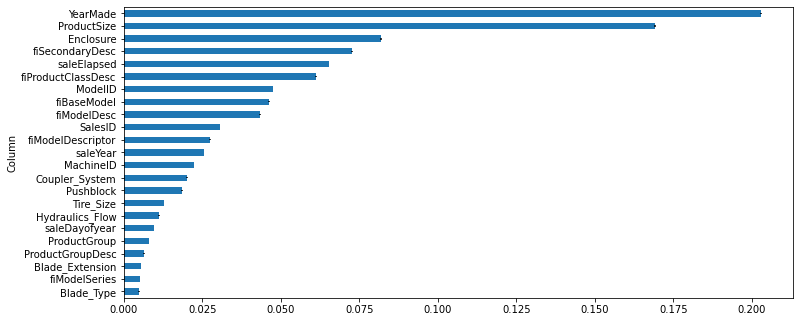

In [332]:
plot_fi(rf_feat_importance(m, xs_imp));

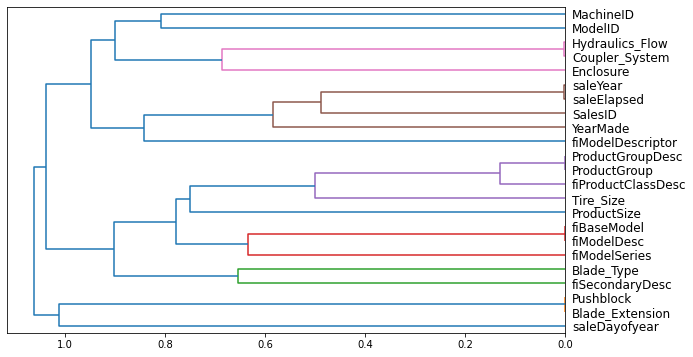

In [333]:
cluster_columns(xs_imp)

In [335]:
def get_oob(xs): return rf(xs, y, min_samples_leaf=15, max_samples=50_000).oob_score_

In [336]:
get_oob(xs_imp)

0.8619428309995821

In [343]:
{c:get_oob(xs_imp.drop(c, axis=1, errors='ignore')) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8611383529538749,
 'saleElapsed': 0.855281465766569,
 'ProductGroupDesc': 0.8632013272346493,
 'ProductGroup': 0.860877953130986,
 'fiModelDesc': 0.8617554703843644,
 'fiBaseModel': 0.8622419354203698,
 'Hydraulics_Flow': 0.8614932859361515,
 'Grouser_Tracks': 0.8637554112260678,
 'Coupler_System': 0.8599988302666252}

In [ ]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

In [ ]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [ ]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [ ]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

In [ ]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

## Interpret the model

### Partial dependence analysis

In [ ]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

### Tree interpreter

In [ ]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [ ]:
row = valid_xs_final.iloc[:5]

In [ ]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [ ]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

## Find out-of-domain data

In [ ]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

In [ ]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

In [ ]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

In [ ]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [ ]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

## Use a neural network

In [ ]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [ ]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [ ]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [ ]:
df_nn_final[cat_nn].nunique()

In [ ]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

In [ ]:
cat_nn.remove('fiModelDescriptor')

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [ ]:
dls = to_nn.dataloaders(1024)

In [ ]:
y = to_nn.train.y
y.min(),y.max()

In [ ]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

In [ ]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

In [ ]:
learn.save('nn')

In [ ]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [ ]:
r_mse(ens_preds,valid_y)